In [26]:
import allel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split


# Load the VCF and inspect the data

In [ ]:
vcf_file = 'Data/GUSG_SNPs.vcf'

# Read the VCF file
callset = allel.read_vcf(vcf_file, fields=['samples', 'calldata/GT'])
print(callset.keys())

dict_keys(['samples', 'calldata/GT'])


/Users/elifried/Library/Python/3.9/lib/python/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


# Process SNP Data

- Extract genotype data
- Converting Genotypes to Numerical Format
- Handling Missing Data

## Explanation
GenotypeArray.to_n_alt(): Converts genotypes to the number of alternate alleles (0, 1, 2).

Handling Missing Data: Missing genotypes can be problematic so I replace them with the mean allele frequency of that SNP.

In [3]:
# Get the genotype data
genotypes = callset['calldata/GT']  # Shape: (num_variants, num_samples, ploidy)
samples = callset['samples']        # List of sample IDs

# Convert genotypes to a 2D array (variants x samples)
genotype_array = allel.GenotypeArray(genotypes)
# Convert to allele counts (0, 1, 2)
allele_counts = genotype_array.to_n_alt()  # Number of alternate alleles

# Replace missing data (nan) with the mean allele frequency for that SNP
allele_counts = allele_counts.astype(float)
mask = np.isnan(allele_counts)
mean_allele_freq = np.nanmean(allele_counts, axis=1)
allele_counts[mask] = np.take(mean_allele_freq, np.where(mask)[0])

# Dimensionality Reduction with PCA
1. Standardizing the Data
2. Applying PCA
3. Selecting Number of Components

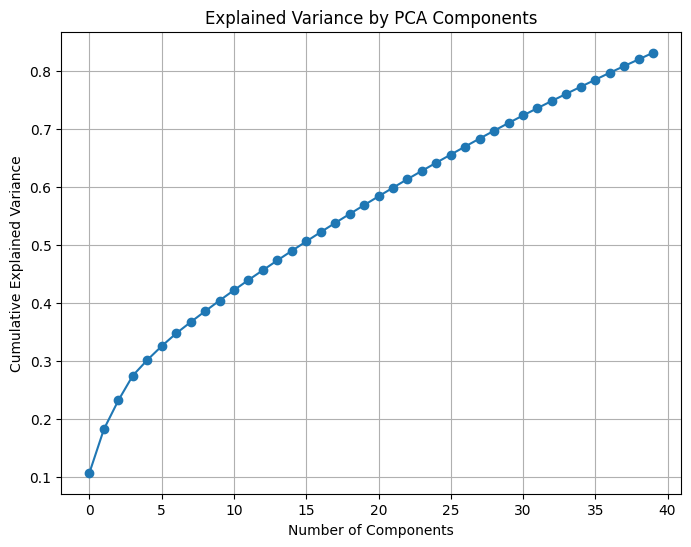

In [ ]:
# Transpose allele_counts to shape (samples x variants)
allele_counts_T = allele_counts.T  # Shape: (samples, variants)

# Standardize the training data
scaler = StandardScaler()
X_std = scaler.fit_transform(allele_counts_T)

pca = PCA(n_components=40)
principal_components_train = pca.fit_transform(X_std)

# Plot cumulative explained variance
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Finding the Ideal Number of Components

Running PCA with only two components shows clustering of the individuals similar to that of the paper when plotting PC1 vs PC2 despite only representing a portion of the variation. 

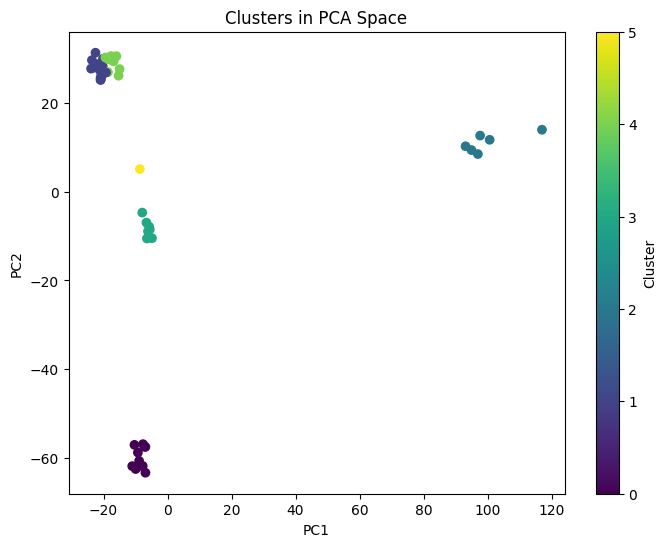

In [ ]:
pca_final = PCA(n_components=2)
pca_2_data = pca_final.fit_transform(X_std)
kmeans_2 = KMeans(n_clusters=6, random_state=42)
clusters_2 = kmeans_2.fit_predict(pca_2_data)

plt.figure(figsize=(8,6))
plt.scatter(pca_2_data[:,0], pca_2_data[:,1], c=clusters_2, cmap='viridis')
plt.title("Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()
